In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [a93c6f00] DataFrames v1.8.0
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [2]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [21]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:init_type, :T, :Lx, :Ly, :Mag, :Energy, :ηz, :ηxy, :spink_corrs]
)
# Parse and return DataFrame of sweep and measure times
function parsetimes(filepath::AbstractString)
    data = DataFrame(ResultTools.dataframe("../jobs/afm-fe-center.results.json"))
    return data[:, [:T, :_ll_sweep_time, :_ll_measure_time]]
end

parsetimes (generic function with 1 method)

In [4]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

In [5]:
function generate_spins(jobname, task_no)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

In [6]:
function generate_mctime_plot(jobname, task_no::Int, observable::Symbol, fig=Figure(size=(800, 400)),
                              fig_pos=(1, 1))
    ax = fig[fig_pos...] = Axis(
        fig,
        title="$observable vs. Bin #",
        xlabel="Bin #",
        ylabel="$observable",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]

        samples = read(observables, "$observable/samples")
        n = length(samples)
        init = 1
        lines!(ax, collect(1:n), samples[1:n])
    end

    return fig
end

generate_mctime_plot (generic function with 3 methods)

## AFM-FE Phase Border

In [7]:
jobname = "afm-fe"
data = cleandata("../jobs/$jobname.results.json")

ArgumentError: ArgumentError: column name :spin_ks not found in the data frame

In [8]:
parsetimes("../jobs/$jobname.results.json")

Row,T,_ll_sweep_time,_ll_measure_time
,Float64,Measurem…,Measurem…
1,0.01,0.00023281±5.9e-7,8.8e-5±1.6e-5
2,0.025,0.00023502±8.8e-7,7.32e-5±5.0e-6
3,0.05,0.00023569±8.9e-7,6.84e-5±3.0e-6
4,0.075,0.0002415±1.7e-6,7.0e-5±3.5e-6
5,0.1,0.0002712±7.5e-6,9.14e-5±7.5e-6
6,0.125,0.00024719±3.6e-7,6.64e-5±2.4e-6
7,0.15,0.00024642±1.9e-7,6.58e-5±2.4e-6
8,0.175,0.00024605±4.4e-7,6.62e-5±2.3e-6
9,0.2,0.00024469±2.0e-7,6.55e-5±2.6e-6


In [9]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

UndefVarError: UndefVarError: `data` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.
Hint: a global variable of this name also exists in BaseDirs.

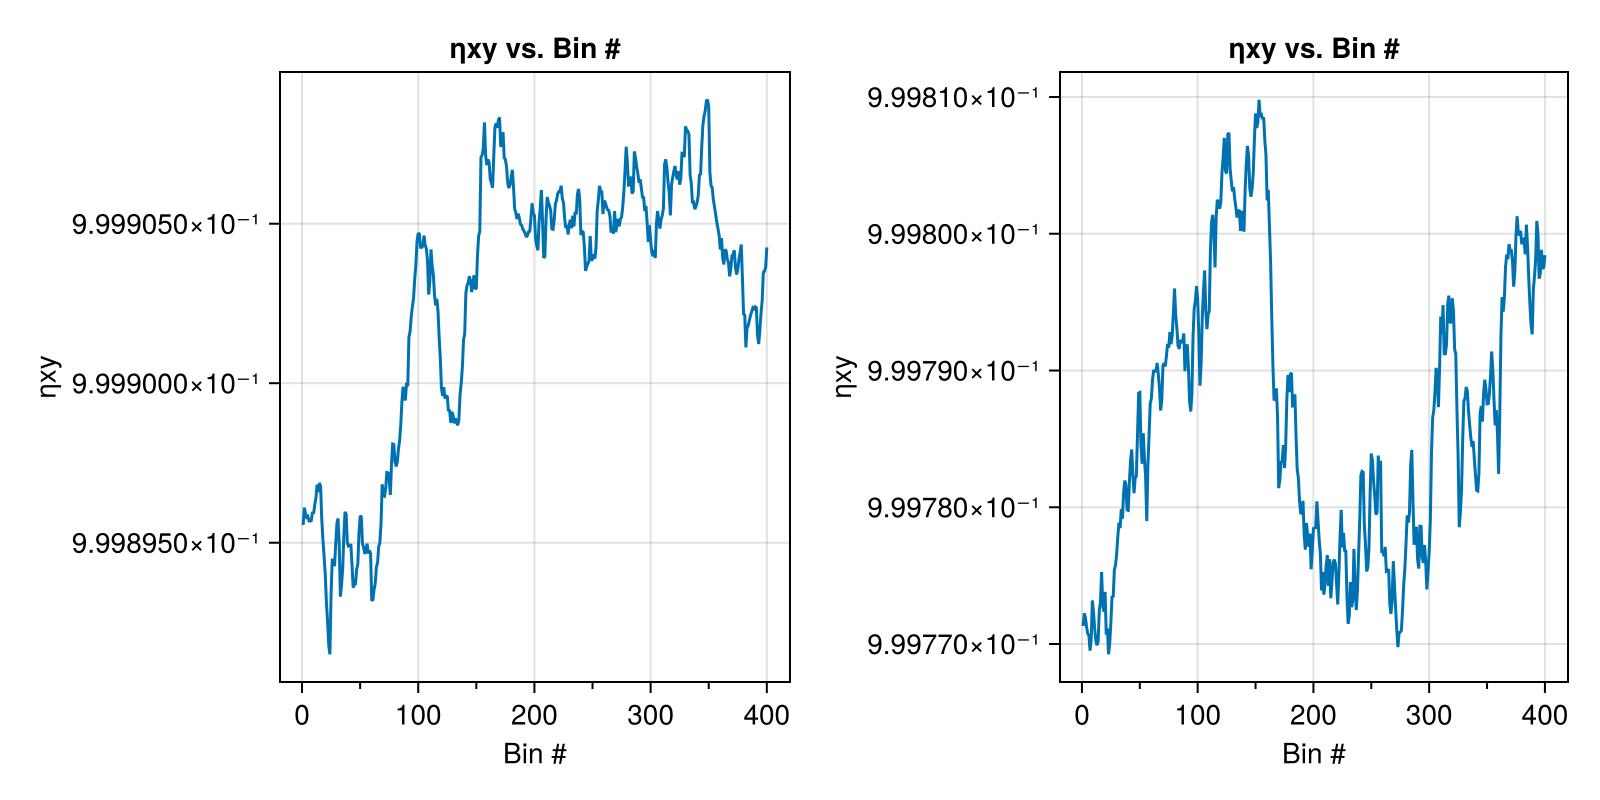

In [10]:
fig = Figure(size=(400, 800))
i = 1
fig = generate_mctime_plot(jobname, i, :ηxy)
generate_mctime_plot(jobname, i+1, :ηxy, fig, (1, 2))

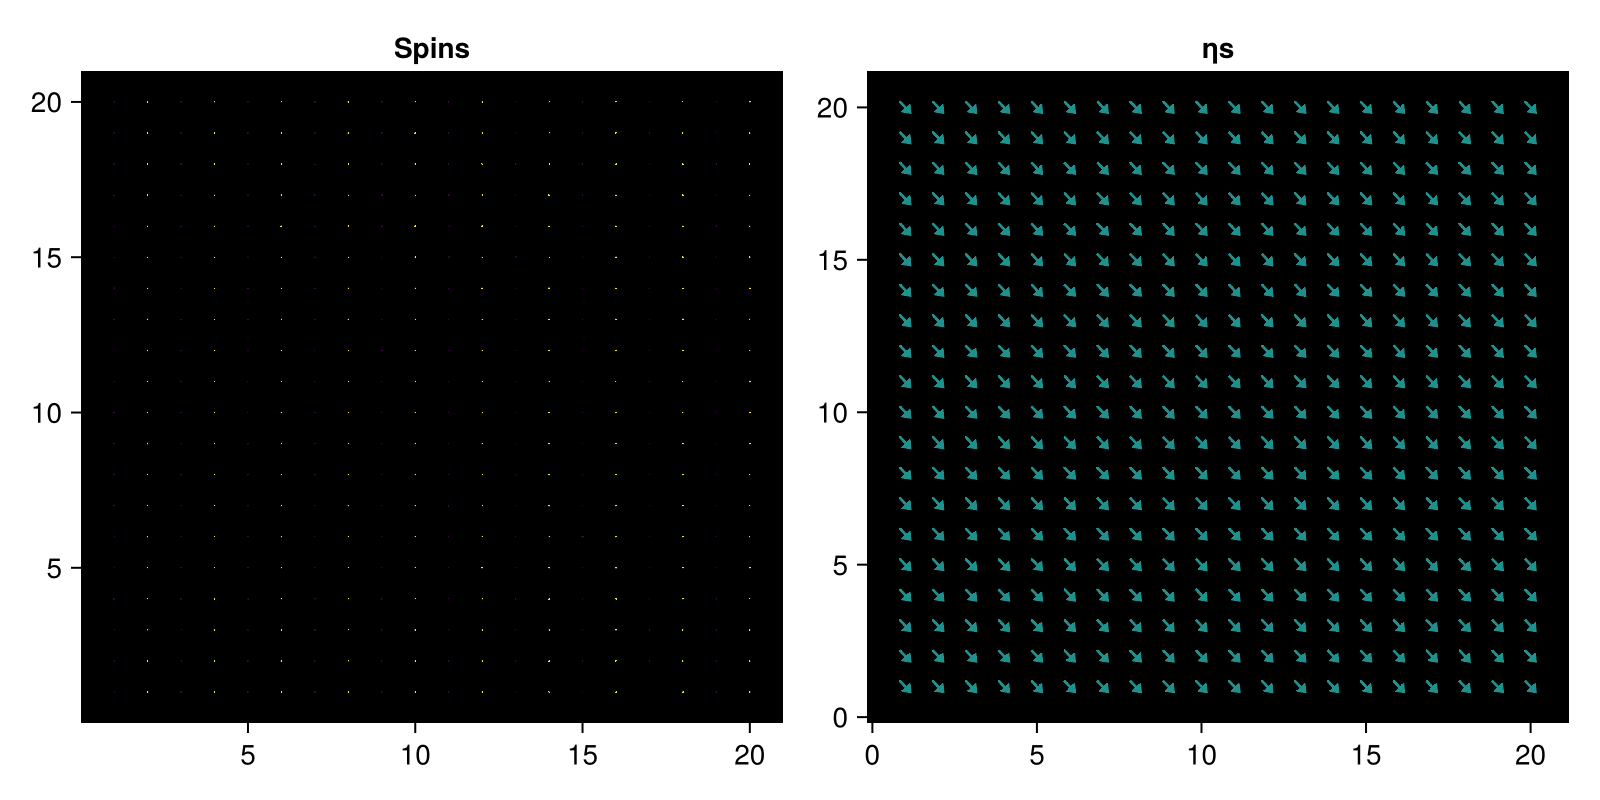

In [11]:
generate_spins(jobname, 1)

## AFM-FE Phase Center

In [37]:
jobname = "afm-fe-center"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,init_type,T,Lx,Ly,Mag,Energy,ηz,ηxy,spink_corrs
,String,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Array…
1,afm_fe,0.01,20,20,0.000276±3.0e-5,-92.103±0.0016,0.000266±6.8e-5,0.999943±6.4e-7,Measurement{Float64}[0.0154±0.0032 0.0298±0.0048 … 0.022±0.0036 0.0298±0.0048; 0.0171±0.002 0.031±0.0026 … 0.0317±0.006 0.0173±0.0015; … ; 0.0291±0.0041 0.0278±0.0039 … 0.0134±0.003 0.0221±0.0031; 0.0171±0.002 0.0173±0.0015 … 0.0223±0.0022 0.031±0.0026]
2,afm_fe,0.025,20,20,0.000578±4.8e-5,-92.1054±0.0048,0.00036±0.00013,0.999866±2.2e-6,Measurement{Float64}[0.066±0.011 0.0643±0.0057 … 0.0511±0.0069 0.0643±0.0057; 0.0563±0.0055 0.0622±0.0091 … 0.062±0.0085 0.0555±0.0068; … ; 0.0558±0.0058 0.112±0.022 … 0.0629±0.0083 0.065±0.01; 0.0563±0.0055 0.0555±0.0068 … 0.072±0.013 0.0622±0.0091]
3,afm_fe,0.05,20,20,0.000683±4.9e-5,-92.009±0.012,0.00035±0.00016,0.999721±4.9e-6,Measurement{Float64}[0.096±0.013 0.123±0.01 … 0.145±0.019 0.123±0.01; 0.0977±0.0091 0.1099±0.0078 … 0.193±0.021 0.116±0.011; … ; 0.168±0.012 0.166±0.023 … 0.105±0.013 0.111±0.011; 0.0977±0.0091 0.116±0.011 … 0.142±0.016 0.1099±0.0078]
4,afm_fe,0.075,20,20,0.0152±0.0024,-61.3±5.5,-0.00016±0.00034,0.4±0.11,Measurement{Float64}[60.0±11.0 62.0±11.0 … 67.0±12.0 62.0±11.0; 63.0±11.0 63.0±11.0 … 72.0±13.0 65.0±12.0; … ; 67.0±12.0 72.0±13.0 … 67.0±12.0 65.0±12.0; 63.0±11.0 65.0±12.0 … 64.0±12.0 63.0±11.0]
5,afm_fe,0.1,20,20,0.0171±0.0022,-56.8±5.0,0.00052±0.00028,0.319±0.098,Measurement{Float64}[70.0±10.0 71.0±10.0 … 77.0±11.0 71.0±10.0; 71.0±10.0 72.0±10.0 … 82.0±12.0 76.0±11.0; … ; 77.0±11.0 81.0±12.0 … 77.0±11.0 75.0±11.0; 71.0±10.0 76.0±11.0 … 74.0±11.0 72.0±10.0]
6,afm_fe,0.125,20,20,0.022518±9.6e-5,-44.375±0.083,-0.00024±0.00021,0.0767±0.0013,Measurement{Float64}[95.58±0.84 96.85±0.67 … 103.74±0.73 96.85±0.67; 96.42±0.52 97.62±0.77 … 110.9±1.0 102.3±0.61; … ; 105.29±0.92 110.72±0.79 … 102.92±0.67 101.33±1.0; 96.42±0.52 102.3±0.61 … 101.65±0.92 97.62±0.77]
7,afm_fe,0.15,20,20,0.022496±7.0e-5,-44.249±0.094,0.00031±0.00035,0.0767±0.0017,Measurement{Float64}[95.69±0.6 97.25±0.77 … 104.12±0.5 97.25±0.77; 97.63±0.73 97.64±0.68 … 110.81±0.91 101.68±0.63; … ; 103.79±0.78 111.7±0.88 … 103.37±0.92 102.29±0.73; 97.63±0.73 101.68±0.63 … 102.21±0.68 97.64±0.68]
8,afm_fe,0.175,20,20,0.02248±0.0001,-44.207±0.065,-0.00018±0.00035,0.0751±0.0012,Measurement{Float64}[95.19±0.87 97.6±0.71 … 103.35±0.65 97.6±0.71; 98.33±0.8 98.12±0.73 … 111.89±0.72 101.1±0.7; … ; 104.36±0.6 112.4±1.0 … 102.99±0.67 102.27±0.69; 98.33±0.8 101.1±0.7 … 100.79±0.57 98.12±0.73]
9,afm_fe,0.2,20,20,0.02272±0.0001,-44.084±0.076,-0.00052±0.00035,0.0742±0.0016,Measurement{Float64}[97.12±0.86 97.5±0.84 … 105.0±0.99 97.5±0.84; 97.63±0.5 98.24±0.61 … 111.69±0.75 103.06±0.47; … ; 104.61±0.47 111.7±0.74 … 105.33±0.6 102.5±0.86; 97.63±0.5 103.06±0.47 … 103.18±0.75 98.24±0.61]


In [38]:
parsetimes("../jobs/$jobname.results.json")

Row,T,_ll_sweep_time,_ll_measure_time
,Float64,Measurem…,Measurem…
1,0.01,0.0002334±1.2e-6,0.000107±2.3e-5
2,0.025,0.0002409±4.8e-6,0.0001015±9.3e-6
3,0.05,0.00023386±2.3e-7,8.5e-5±3.4e-6
4,0.075,0.0002429±1.1e-6,8.63e-5±3.4e-6
5,0.1,0.0002447±1.2e-6,8.62e-5±3.5e-6
6,0.125,0.00024894±3.4e-7,8.68e-5±2.8e-6
7,0.15,0.00024769±5.6e-7,8.69e-5±3.5e-6
8,0.175,0.00024775±6.4e-7,8.58e-5±2.9e-6
9,0.2,0.00024588±4.8e-7,8.44e-5±2.9e-6


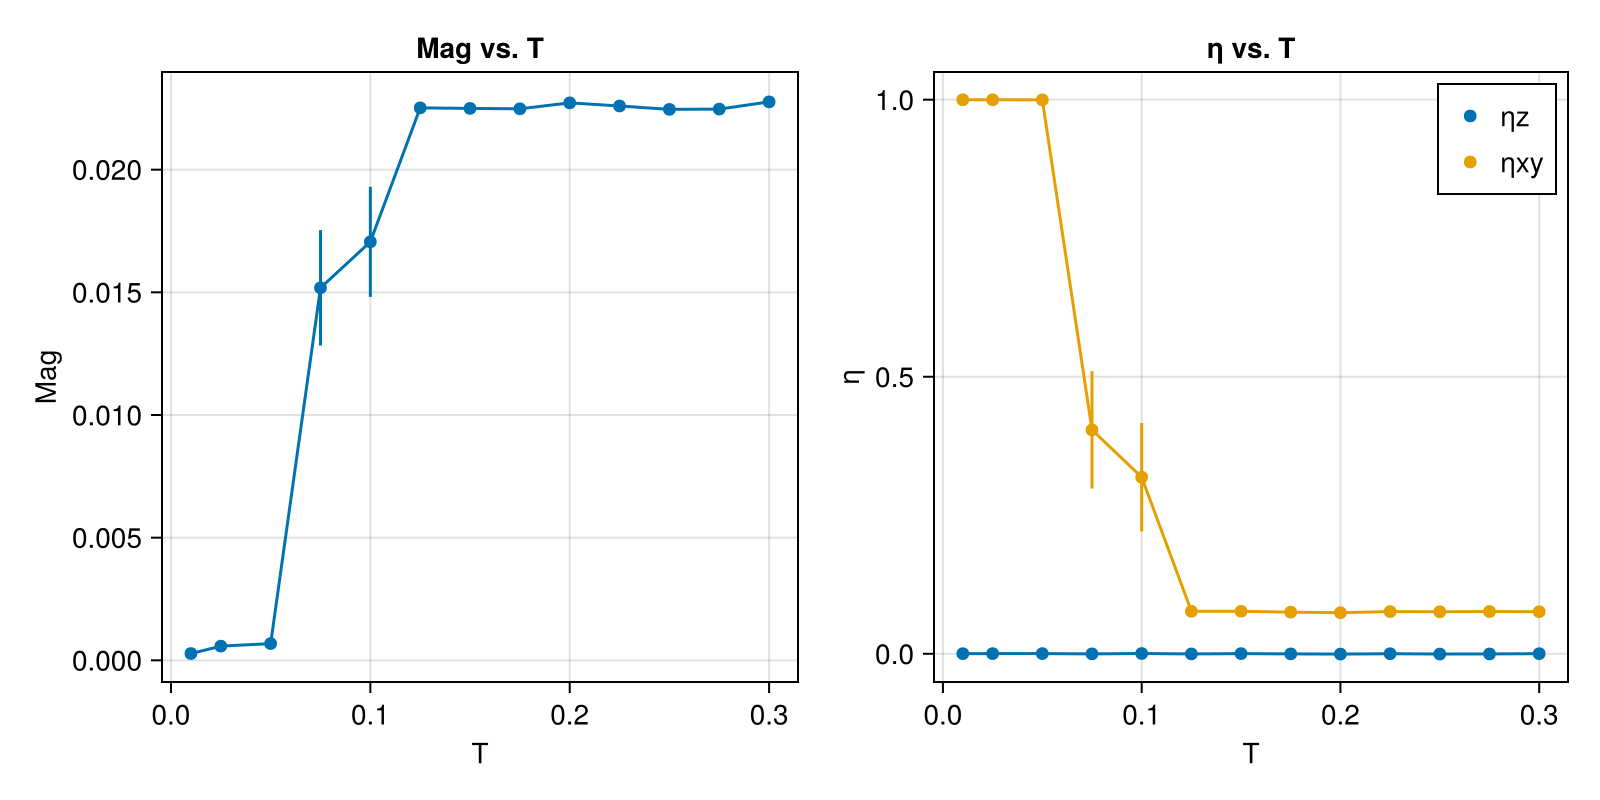

In [39]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

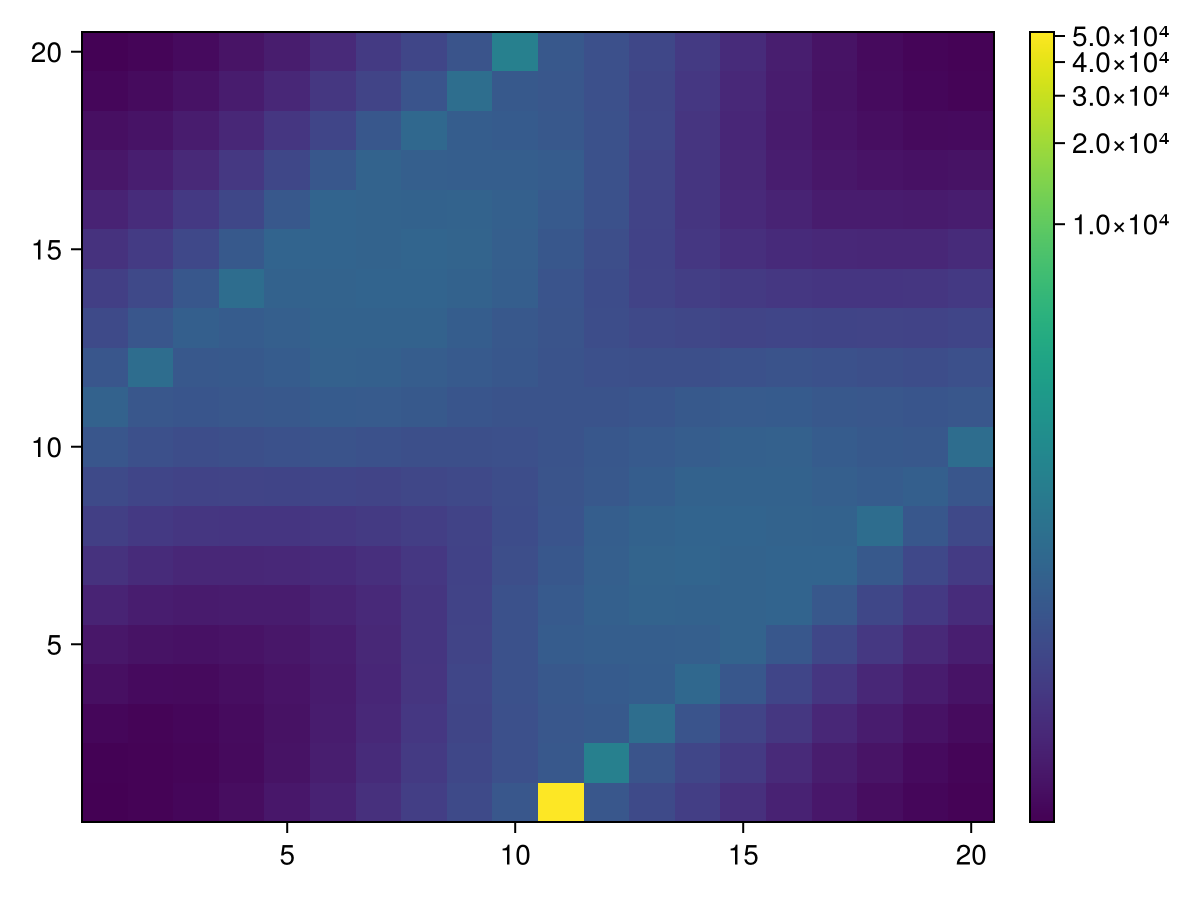

In [40]:
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
spink_corrs = getfield.(data[4, :spink_corrs], :val)
fig, ax, hm = heatmap(spink_corrs, colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

In [41]:
to_triangle((x, y)) = ((x-1), (-(x-1) + 2(y-1)) / sqrt(3)) ./ 20
positions = collect(map(to_triangle, Iterators.product(axes(spink_corrs)...)))

20×20 Matrix{Tuple{Float64, Float64}}:
 (0.0, 0.0)          …  (0.0, 1.03923)    (0.0, 1.09697)
 (0.05, -0.0288675)     (0.05, 1.01036)   (0.05, 1.0681)
 (0.1, -0.057735)       (0.1, 0.981495)   (0.1, 1.03923)
 (0.15, -0.0866025)     (0.15, 0.952628)  (0.15, 1.01036)
 (0.2, -0.11547)        (0.2, 0.92376)    (0.2, 0.981495)
 (0.25, -0.144338)   …  (0.25, 0.894893)  (0.25, 0.952628)
 (0.3, -0.173205)       (0.3, 0.866025)   (0.3, 0.92376)
 (0.35, -0.202073)      (0.35, 0.837158)  (0.35, 0.894893)
 (0.4, -0.23094)        (0.4, 0.80829)    (0.4, 0.866025)
 (0.45, -0.259808)      (0.45, 0.779423)  (0.45, 0.837158)
 (0.5, -0.288675)    …  (0.5, 0.750555)   (0.5, 0.80829)
 (0.55, -0.317543)      (0.55, 0.721688)  (0.55, 0.779423)
 (0.6, -0.34641)        (0.6, 0.69282)    (0.6, 0.750555)
 (0.65, -0.375278)      (0.65, 0.663953)  (0.65, 0.721688)
 (0.7, -0.404145)       (0.7, 0.635085)   (0.7, 0.69282)
 (0.75, -0.433013)   …  (0.75, 0.606218)  (0.75, 0.663953)
 (0.8, -0.46188)        (0.8, 0.5

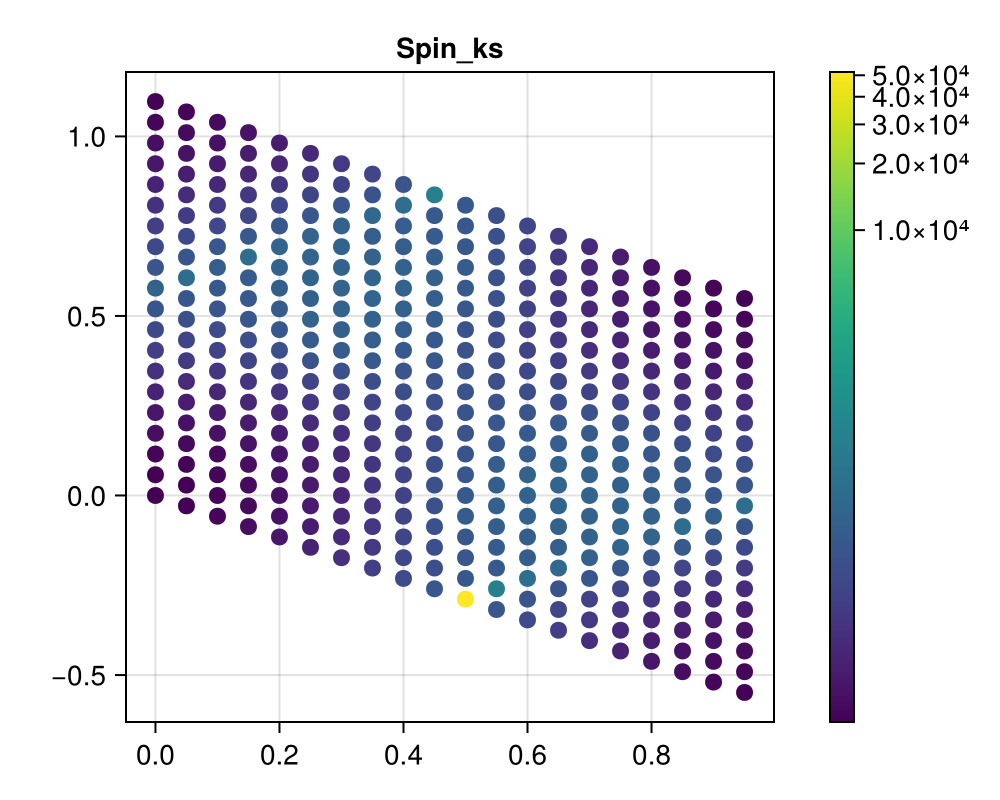

In [42]:
fig = Figure(size=(500, 400))
scale = ReversibleScale(log)
ax = fig[1,1] = Axis(fig, title="Spin_ks", aspect=1)

xs = collect(Iterators.flatten(getindex.(positions, 1)))
ys = collect(Iterators.flatten(getindex.(positions, 2)))
sc = scatter!(
    xs, ys,
    color=collect(Iterators.flatten(spink_corrs)),
    colorscale=scale,
    markersize=12
)
Colorbar(fig[1, 2], sc)
fig

In [43]:
collect(Iterators.flatten(spin_ks))

UndefVarError: UndefVarError: `spin_ks` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

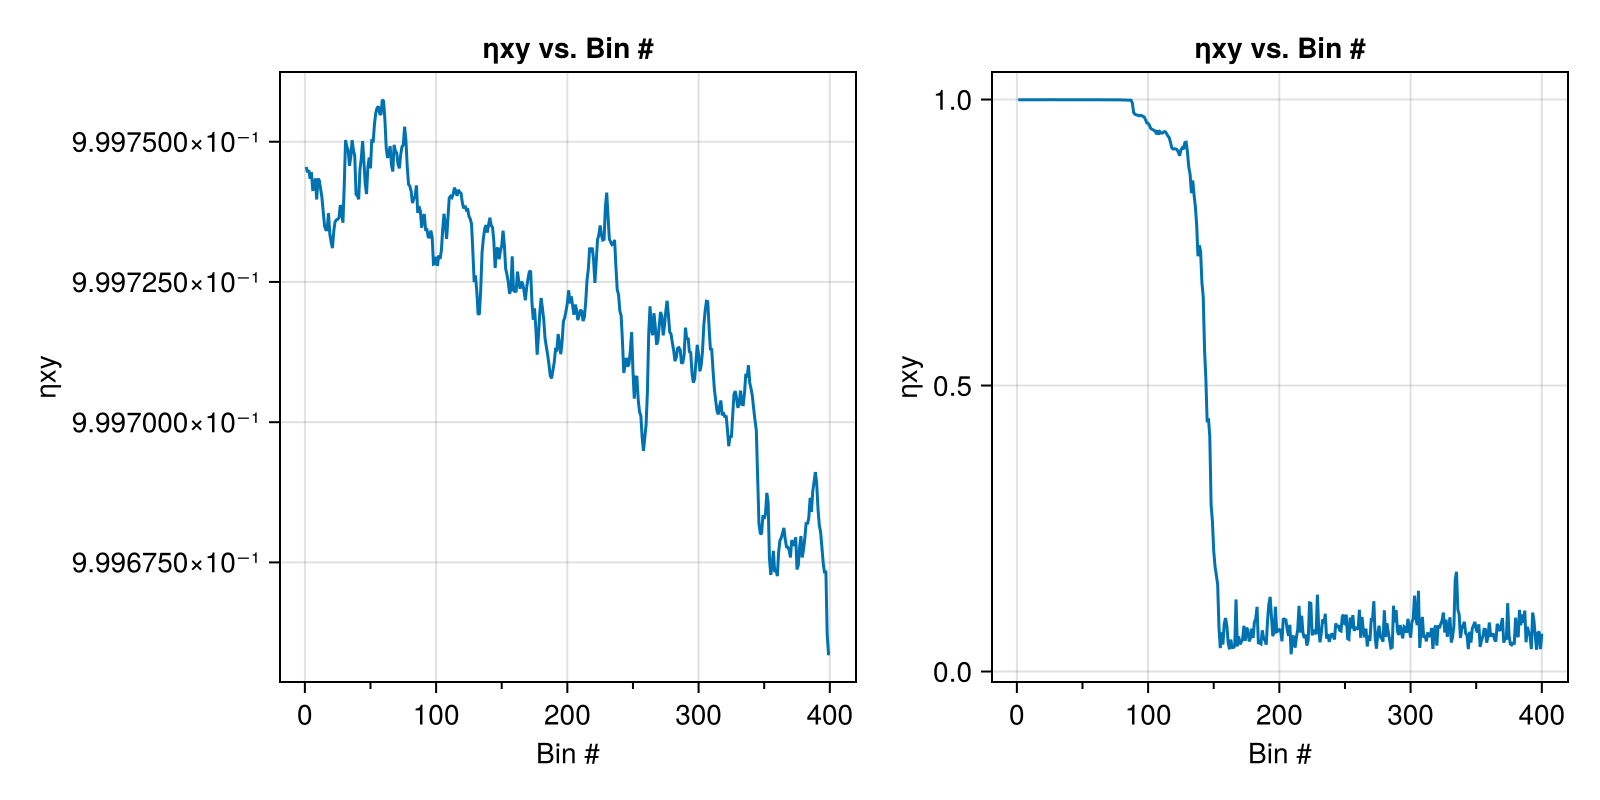

In [44]:
fig = Figure(size=(400, 800))
i = 3
fig = generate_mctime_plot(jobname, i, :ηxy)
generate_mctime_plot(jobname, i+1, :ηxy, fig, (1, 2))

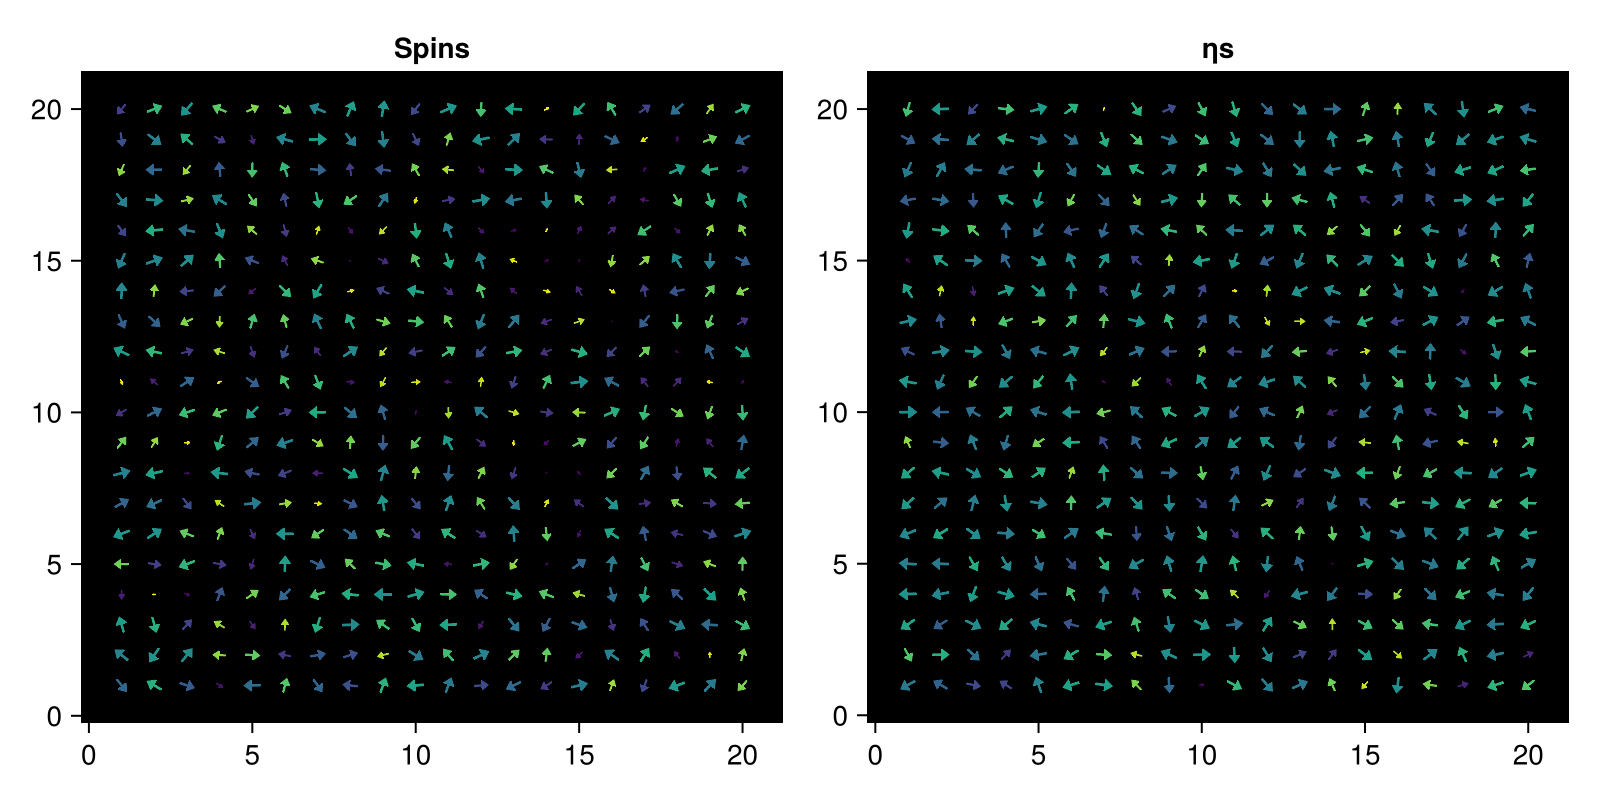

In [45]:
generate_spins(jobname, 4)